In [0]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import math
import scipy.interpolate as interp
import pandas as pd
from importlib import import_module
import csv

In [0]:
def get_signal_peaks_and_mins(red,blue, red_subplt, blue_subplt, cut_points):   
    # find red peaks -> pluse
    data_set = pd.DataFrame({'red':red, 'blue': blue})
    window = 0.75
    fs=30
    move_avg = data_set['red'].rolling(int(window*fs)).mean()
    avg_red = data_set['red'].mean()

    max_window = []
    min_window = []
    red_max_list = []
    red_min_list = []

    listpos = 0 

    for datapoint in data_set.red:
        rollingmean = move_avg[listpos]
        if (datapoint > rollingmean): 
            max_window.append(datapoint)
            listpos += 1
            if len(min_window) > 0:
                min_pos = listpos - len(min_window) + (min_window.index(min(min_window)))-1
                red_min_list.append(min_pos)
                min_window = []
            
        else:  # we add points below the MA to the min window
            min_window.append(datapoint)
            listpos += 1
            if len(max_window) > 0:
                max_pos = listpos - len(max_window) + (max_window.index(max(max_window))) -1
                red_max_list.append(max_pos) 
                max_window = [] 
                
                
            

    red_peaks = [data_set.red[x] for x in red_max_list]

    red_mins = [data_set.red[x] for x in red_min_list] 

    blue_max_list = []
    blue_min_list = []

    for i, max_ind in enumerate(red_max_list):
        
        # Determine the last index we should look at for the window
        last_ind = 0
        if i ==(len(red_max_list)-1):
            last_ind = data_set.blue.size-1
        else:
            last_ind= red_max_list[i+1]

        # Determine the first index (where the last maximum is)
        start_ind = blue_max_list[i-1] if len(blue_max_list) >0 else max_ind

        # Find the min
        blue_min_ind = np.argmin(data_set.blue[start_ind: last_ind])
        blue_min_list.append(start_ind + blue_min_ind)

        # Find the next max between the min and the end of the period
        blue_max_ind = np.argmax(data_set.blue[start_ind + blue_min_ind: last_ind])
        blue_max_list.append(start_ind + blue_min_ind + blue_max_ind)



    blue_peaks = [data_set.blue[x] for x in blue_max_list] 
    blue_mins = [data_set.blue[x] for x in blue_min_list] 

     
    red_subplt.plot(cut_points,data_set.red, alpha=0.5, color='blue') 
    red_subplt.scatter(cut_points[red_max_list], red_peaks, color='red')
    red_subplt.scatter(cut_points[red_min_list], red_mins, color='green')
    red_subplt.set_title("Red")

    blue_subplt.plot(cut_points,data_set.blue, alpha=0.5, color='blue') 
    blue_subplt.scatter(cut_points[blue_max_list], blue_peaks, color='red')
    blue_subplt.scatter(cut_points[blue_min_list], blue_mins, color='green')
    blue_subplt.set_title("Blue")


    if len(blue_mins) == len(red_mins):
        return red_peaks[1:], red_mins[:-1], blue_peaks[:-1], blue_mins[:-1]
    elif len(red_mins) > len(blue_mins):
        return red_peaks[1:], red_mins[1:-1], blue_peaks[:-1], blue_mins[:-1]
    #return red_peaks, red_mins, blue_peaks, blue_mins

In [0]:
def get_signal_ratio_and_spo2(measurements, red_subplt, blue_subplt):
    meas = import_module(measurements)
    red = getattr(meas,"red")
    blue = getattr(meas,"blue")
    times = getattr(meas,"times")
    spo2 = getattr(meas,"spo2")

    red_array= np.array(red)
    blue_array = np.array(blue)
    time_points = np.array([(t -times[0])/(10**9) for t in times ])

    # Not sure why this happenes
    red_time_diff= len(times) - len(red)
    blue_time_diff = len(times) - len(blue)
    signal_cut = 70

    spaced_time_points = np.arange(0,30,1/30)
    f_red = interp.CubicSpline(time_points[signal_cut+red_time_diff:], red_array[signal_cut:])
    f_blue = interp.CubicSpline(time_points[signal_cut+ blue_time_diff:], blue_array[signal_cut:])

    resampled_red = f_red(spaced_time_points[int(signal_cut*2):len(spaced_time_points)-120])
    resampled_blue = f_blue(spaced_time_points[int(signal_cut*2):len(spaced_time_points)-120])

    cut_points= spaced_time_points[int(signal_cut*2):len(spaced_time_points)-120]


    red_peaks, red_mins, blue_peaks, blue_mins = get_signal_peaks_and_mins(resampled_red,resampled_blue, red_subplt, blue_subplt, cut_points)

    red_ratios = np.array(red_mins)/np.array(red_peaks)
    blue_ratios = np.array(blue_mins)/np.array(blue_peaks)
    ratios = red_ratios/blue_ratios
   
    return ratios, spo2


721
722
723
724
725
726
727


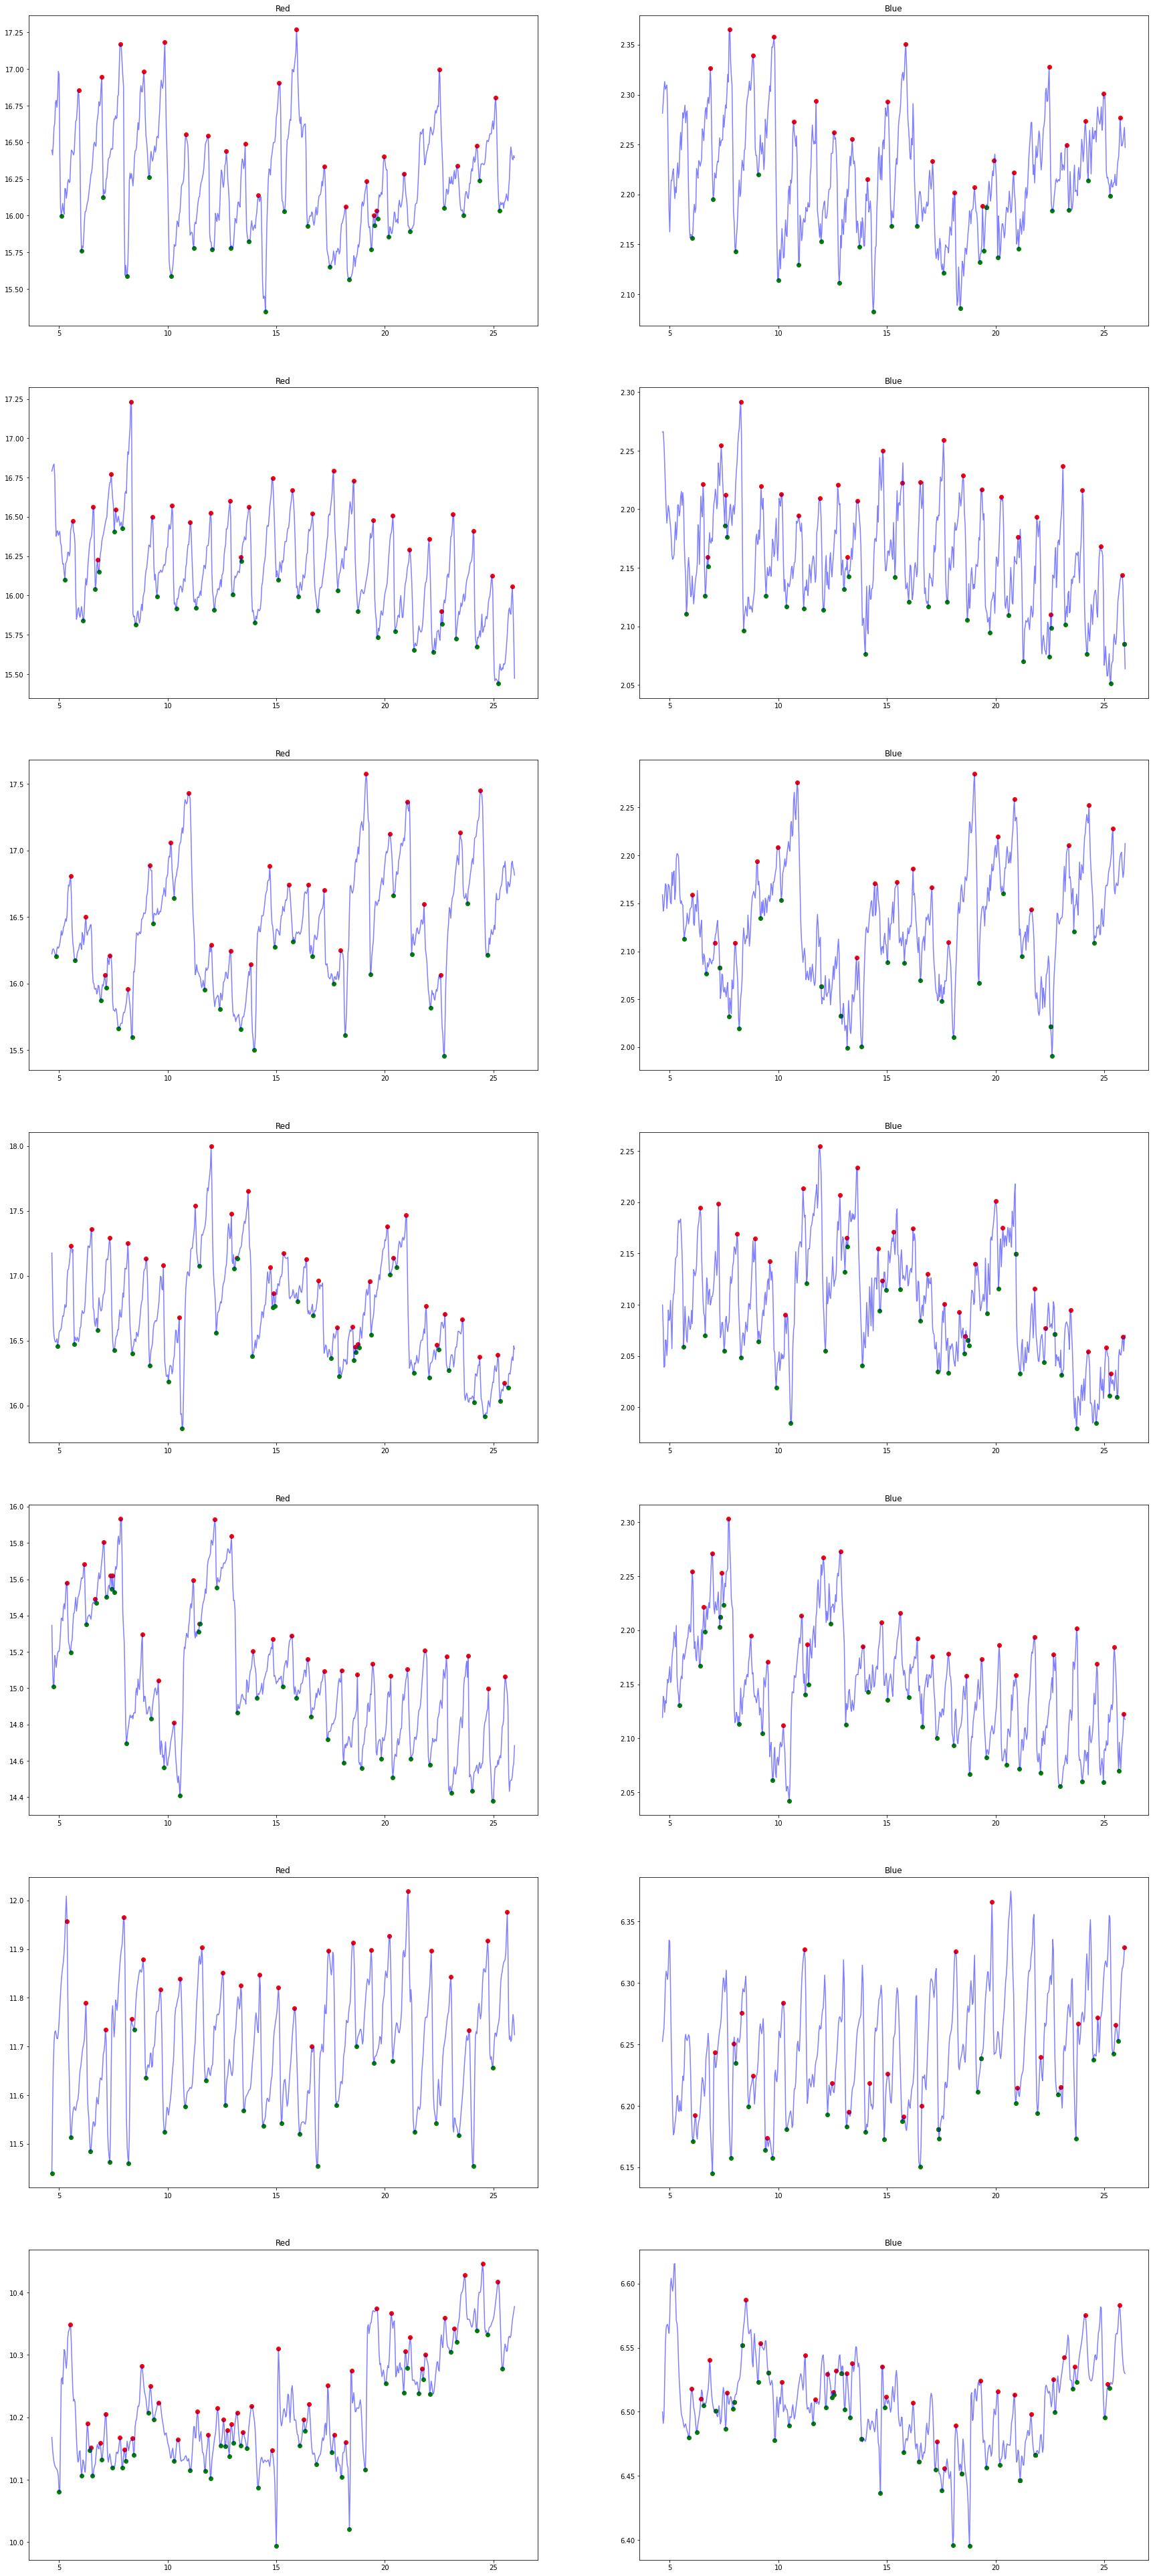

In [0]:
measurements = ['raw_measurements.galaxy_1','raw_measurements.galaxy_2','raw_measurements.galaxy_3','raw_measurements.galaxy_4','raw_measurements.galaxy_5', 'raw_measurements.xiaomi_3', 'raw_measurements.xiaomi_4']
ratios = []
spo2s = []
fig = plt.figure(figsize=(30,10*len(measurements)))
for i,measu in enumerate(measurements):
    red_subplt = fig.add_subplot(len(measurements),2,i*2+1)
    blue_subplt = fig.add_subplot(len(measurements),2,i*2+2)
    rat, spo2 = get_signal_ratio_and_spo2(measu, red_subplt, blue_subplt)
    ratios.append(rat.mean())
    spo2s.append(spo2)


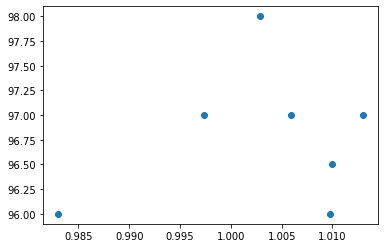

In [0]:
plt.scatter(ratios, spo2s)

In [0]:
import keras
def build_model():
  